In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
from PIL import Image
from skimage import io
import random  

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [3]:
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing import image

## Load Dataset

In [4]:
path = r'C:\Users\justi\Data Science\Rice_Image_Dataset'
categories = [class_name for class_name in os.listdir(path) if class_name]
categories.remove('Rice_Citation_Request.txt')
print(categories)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


### Preprocess

In [5]:
dataset = []
for class_name in categories:
    Categories_path = os.path.join(path, class_name)  #get the classes of label
    images = os.listdir(Categories_path) #Find the images files' name of all class
    for img in images:
        img_path = os.path.join(Categories_path, img) #get the images of each class
        dataset.append((img_path, class_name))  # Dataset list creation
            
df = pd.DataFrame(dataset, columns=['img_path', 'labels'])

df.head()

,img_path,labels
0,C:\Users\justi\Data Science\Rice_Image_Dataset...,Arborio
1,C:\Users\justi\Data Science\Rice_Image_Dataset...,Arborio
2,C:\Users\justi\Data Science\Rice_Image_Dataset...,Arborio
3,C:\Users\justi\Data Science\Rice_Image_Dataset...,Arborio
4,C:\Users\justi\Data Science\Rice_Image_Dataset...,Arborio


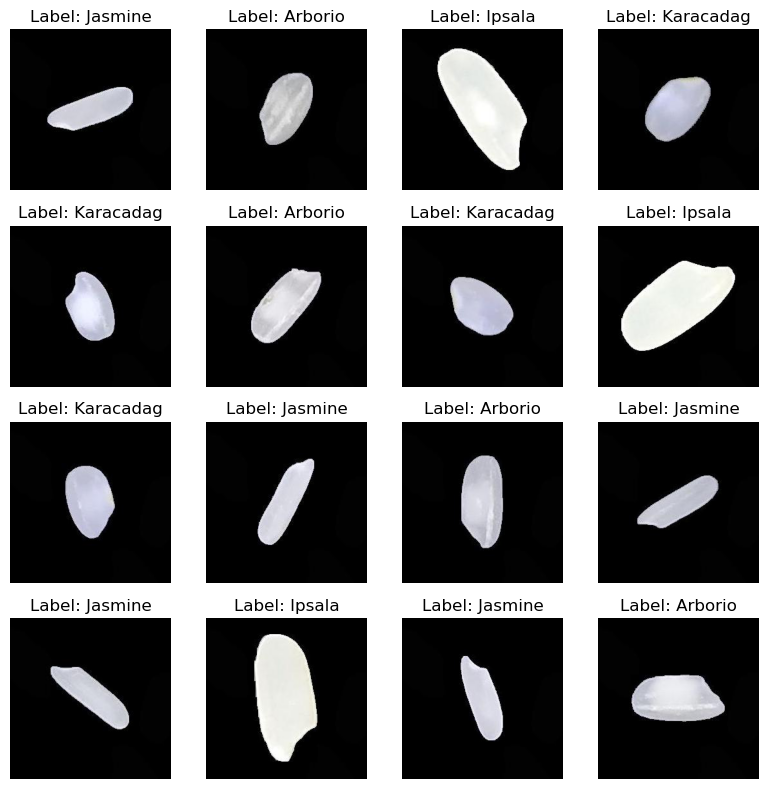

In [6]:
sampled_df = df.sample(n=16, random_state=50)

# Plot the images
plt.figure(figsize=(8, 8))
for i in range(len(sampled_df)):
    plt.subplot(4, 4, i + 1)
    
    img_path = sampled_df.iloc[i]['img_path']
    label = sampled_df.iloc[i]['labels']
    img = keras.utils.load_img(img_path)
    
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

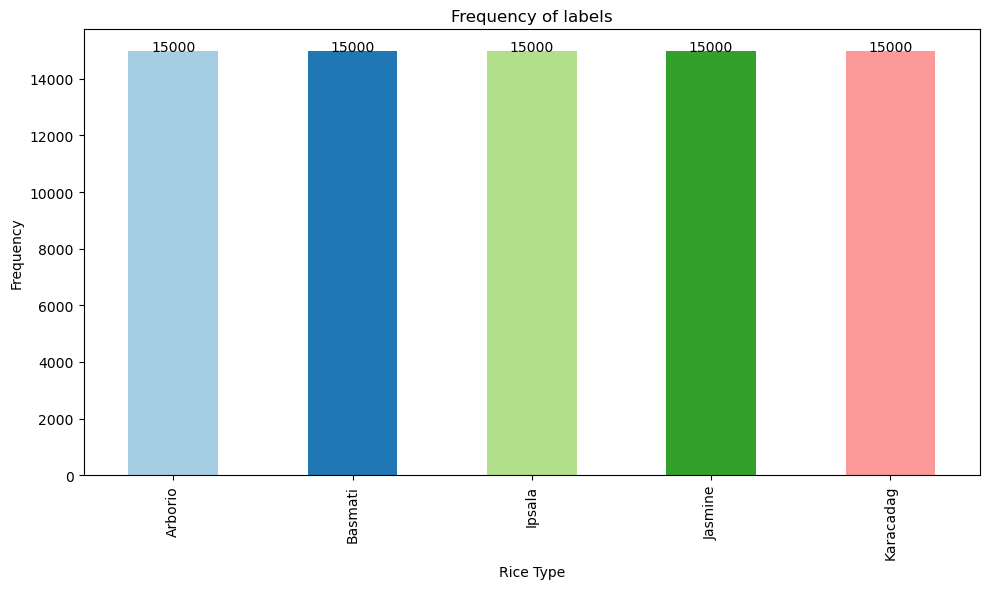

In [7]:
# See if appearence of company is the same in stock dataset
plt.figure(figsize=(10, 6))

label_counts = df['labels'].value_counts()

# Create a bar plot with each bar a different color
colors = plt.cm.Paired(range(len(label_counts)))
ax = df['labels'].value_counts().plot(kind='bar', color=colors)

plt.title('Frequency of labels')
plt.xlabel('Rice Type')
plt.ylabel('Frequency')

for i, count in enumerate(label_counts):
    plt.text(i, count + 0.2, str(count), ha='center')

plt.tight_layout()
plt.show()

In [8]:
# Assuming 'categories' is a list of class names
sample_size = 1000
dataset = []

for class_name in categories:
    Categories_path = os.path.join(path, class_name)  # get the classes of label
    images = os.listdir(Categories_path)  # Find the images files' name of all class
    # Sample 3000 rows from the images list for each class
    sampled_images = random.sample(images, min(len(images), sample_size))
    for img in sampled_images:
        img_path = os.path.join(Categories_path, img)  # get the images of each class
        dataset.append((img_path, class_name))  # Dataset list creation

df = pd.DataFrame(dataset, columns=['img_path', 'labels'])

#### Partitioning Data

In [9]:
from sklearn.model_selection import train_test_split

# First split: 80% training, 20% temporary (validation + test)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=50)

# Second split: Split the temporary set into 50% validation and 50% test
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'], random_state=50)

# Display the distribution of classes in the training, validation, and testing sets
print("\nTraining set class distribution:")
print(train_df['labels'].value_counts())

print("\nValidation set class distribution:")
print(val_df['labels'].value_counts())

print("\nTesting set class distribution:")
print(test_df['labels'].value_counts())


Training set class distribution:
labels
Arborio      800
Basmati      800
Jasmine      800
Karacadag    800
Ipsala       800
Name: count, dtype: int64

Validation set class distribution:
labels
Ipsala       100
Jasmine      100
Basmati      100
Arborio      100
Karacadag    100
Name: count, dtype: int64

Testing set class distribution:
labels
Jasmine      100
Ipsala       100
Karacadag    100
Arborio      100
Basmati      100
Name: count, dtype: int64


In [10]:
image_size = (128, 128)
batch_size = 20

# Create an ImageDataGenerator object with rescale options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255
)


# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='img_path',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the validation data
valid_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='img_path',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Create a generator for the test data
test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='img_path',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4000 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


## Modeling

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten

# Initialize the model
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(filters=32, kernel_size=2, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    
    Conv2D(filters=64, kernel_size=2, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(filters=128, kernel_size=2, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(0.2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5,activation='softmax')
])

#compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
#model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 127, 127, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,432,293 (28.35 MB)

 Trainable params: 7,431,845 (28.35 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
# Model CheckPoint Call-Back, to save best model parameters as a .keras file
checkpoint_cb = keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True) 

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [26]:
#fit model
model.fit(train_generator,epochs=25,validation_data=test_generator,callbacks=[checkpoint_cb, reduce_lr])

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - accuracy: 0.7289 - loss: 1.5507 - val_accuracy: 0.2000 - val_loss: 4.6975 - learning_rate: 0.0010
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - accuracy: 0.9361 - loss: 0.2108 - val_accuracy: 0.3920 - val_loss: 3.6083 - learning_rate: 0.0010
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 122ms/step - accuracy: 0.9671 - loss: 0.0953 - val_accuracy: 0.9180 - val_loss: 0.1948 - learning_rate: 0.0010
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - accuracy: 0.9706 - loss: 0.0834 - val_accuracy: 0.9700 - val_loss: 0.0708 - learning_rate: 0.0010
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.9635 - loss: 0.1223 - val_accuracy: 0.9400 - val_loss: 0.2080 - learning_rate: 0.0010
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.9728 - loss: 0.0765 - val_accuracy: 0.9600 - val_loss: 0.1073 - learning_rate: 0.0010
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.9

In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)

# Print the results
print()
print(f'Loss : {loss}')
print(f'Accuracy : {round(accuracy * 100, 5)}%')

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9891 - loss: 0.0289

Loss : 0.048136670142412186
Accuracy : 99.0%


In [28]:
from sklearn.metrics import classification_report

# Reset the test generator to start from the beginning
test_generator.reset()

# Use the model to predict on the test data generator
y_pred = model.predict(test_generator, verbose=1)

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate classification report
clf_report = classification_report(test_generator.classes, y_pred_labels, target_names=categories)

print(clf_report)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
              precision    recall  f1-score   support

     Arborio       0.97      0.99      0.98       100
     Basmati       1.00      0.99      0.99       100
      Ipsala       1.00      1.00      1.00       100
     Jasmine       0.98      1.00      0.99       100
   Karacadag       1.00      0.97      0.98       100

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


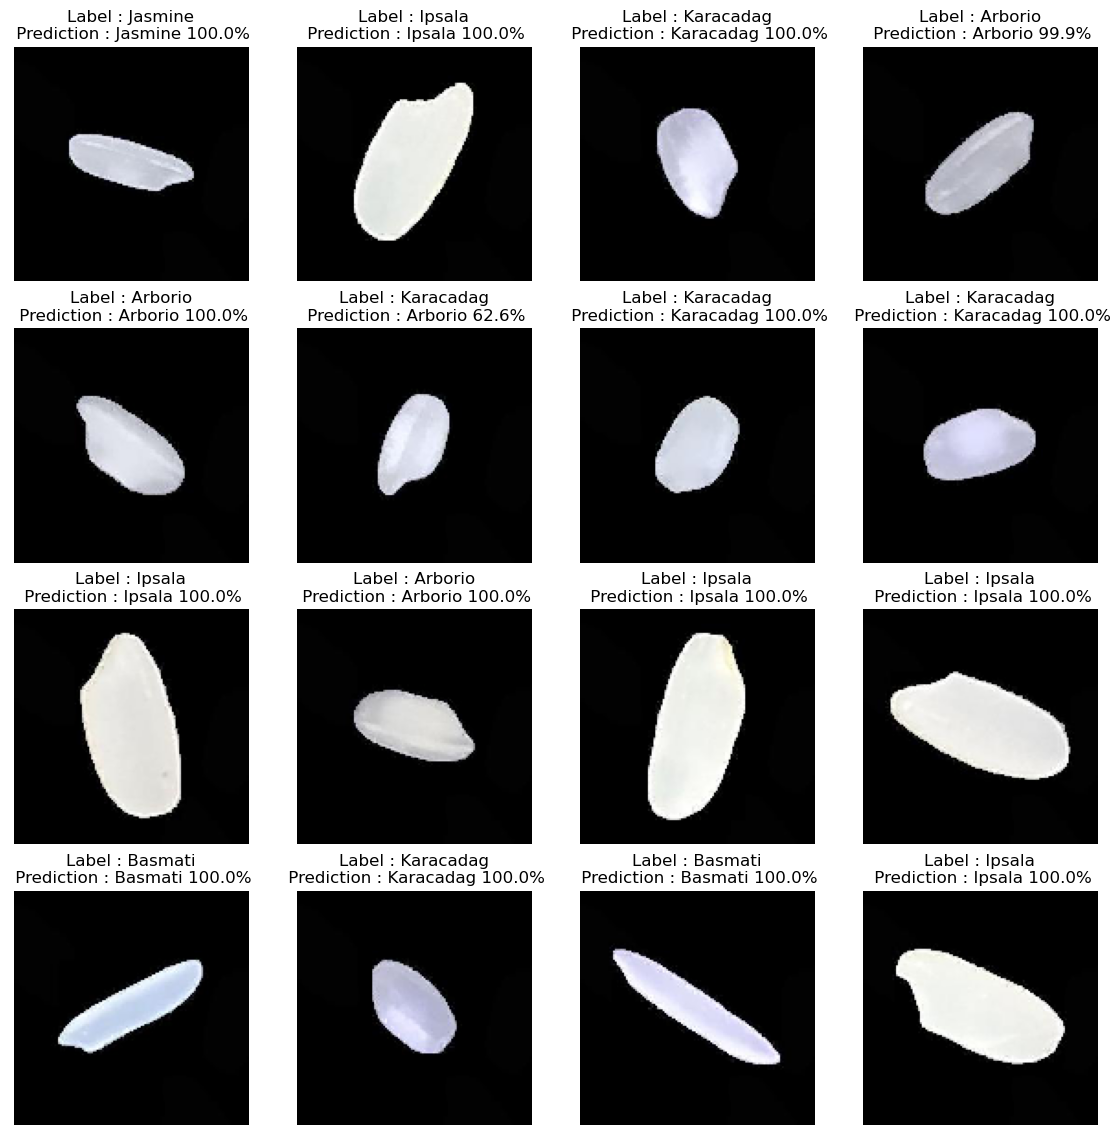

In [29]:
#plot predictions

test_generator.reset()
img, label = next(test_generator)

prediction = model.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(categories[np.argmax(label[i])], categories[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

**Goal:**
Too attempt to build a CNN model that can acuurately class

**Probelms:**
- A confusion matrix was attempted but it wouldn't plot properly
- Keras won't plot the structure of the CNN
- Laptop takes too long to process 105k pictures

**Improvements:** Work on fine tuning model to obtain better scores